In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import numpy as np
import matplotlib.patches as mpatches

In [2]:
save = True
filter_zeros = True

In [3]:
def match_sim_to_actual(sim_df, act_df, group_cols, seed=0):
    """
    For every unique combination of `group_cols`, sample from `sim_df`
    so the sample size equals the size of the corresponding group in `act_df`.
    """
    rng = np.random.default_rng(seed)
    
    # Compute desired sample size per group from the Actual panel
    target_sizes = (
        act_df
        .groupby(group_cols, observed=True)
        .size()
        .rename("target")
        .reset_index()
    )
    
    # Add a 'target' column to Simulation rows by merging
    sim_tagged = (
        sim_df
        .merge(target_sizes, on=group_cols, how="left")
        # If a group appears only in Simulation, keep 0 target (drop later)
        .fillna({"target": 0})
    )
    
    # Function to sample within each group
    def _sampler(group):
        n = int(group["target"].iloc[0])
        if n <= 0:
            return group.iloc[0:0]          # return empty
        # Need reproducible sampling per group; use np.random.Generator.choice
        idx = rng.choice(group.index, size=n, replace=False)
        return group.loc[idx]

    sampled_sim = sim_tagged.groupby(group_cols, observed=True, group_keys=False).apply(_sampler)
    sampled_sim = sampled_sim.drop(columns="target")       # clean up
    return sampled_sim

In [4]:
def strip_upper_outliers(group, k=3):
    """
    Remove rows where 'value' > mean + k*std.
    Works on each metric separately (groupby('metric')).
    """
    mu  = group["value"].mean()
    sig = group["value"].std(ddof=0)
    upper = mu + k * sig
    return group.loc[group["value"] <= upper]

In [5]:
BASE = Path("CV_Experiments")        # adjust if needed
actual_pat = re.compile(r"Standard_Summary_Exceedances_Control_(.+)\.csv")
sim_pat    = re.compile(r"All_Sims_(.+?)_(.+)\.csv")       # run_name , location

# ---------- 1.  read files ----------
actual_dfs = []
sim_dfs    = []

for f in BASE.glob("Standard_Summary_Exceedances_Control_*.csv"):
    loc = actual_pat.match(f.name).group(1)
    df  = pd.read_csv(f)
    df.columns = df.columns.str.lower()        # Lower-case to match simulations
    df["month"]  = pd.to_datetime(df["month"],  format="%Y-%m")   # yyyy-mm
    df["source"] = "Actual"
    df["location"] = loc
    actual_dfs.append(df)

for f in BASE.glob("All_Sims_*_*.csv"):
    run_name, loc = sim_pat.match(f.name).groups()
    df = pd.read_csv(f)
    df.columns = df.columns.str.lower()
    df["month"]  = pd.to_datetime(df["month"])               # yyyy-mm-dd
    df["source"] = f"Sim-{run_name}"
    df["location"] = loc
    df = df.sort_values("month")

    # Extract year, “factorize” it (gives 0,1,2,…) in chronological order,
    #     then make it 1‑based.
    df["time_index"] = df["month"].dt.year.factorize(sort=True)[0] + 1

    
    sim_dfs.append(df)

sim_df    = pd.concat(sim_dfs,   ignore_index=True)

idx_map = (
    sim_df[["location", "month", "time_index"]]
    .drop_duplicates()
)

# overwrite each frame in the list with its merged version
for i, df in enumerate(actual_dfs):
    actual_dfs[i] = df.merge(
        idx_map,
        on=["location", "month"],
        how="left"          # keeps unmatched rows; time_index = NaN
    )

# Concatenate and keep identical column ordering
data = pd.concat(actual_dfs + sim_dfs, ignore_index=True)
actual_df = pd.concat(actual_dfs, ignore_index=True)
metrics = ["frequency", "intensity", "duration", "signal"]

In [6]:
actual_df_zeros = actual_df.copy()
sim_df_zeros = sim_df.copy()
if filter_zeros:
    actual_df = actual_df[actual_df["frequency"] != 0].copy()
    sim_df    = sim_df[sim_df["frequency"]    != 0].copy()

In [7]:
metrics_mon   = ["frequency", "signal"]
metrics_storm = ["intensity", "duration"]
metrics   = metrics_mon + metrics_storm

# ───── 0.  Surrogate storm ID for ACTUAL  ─────────────────────────
actual_df["storm_index"] = (
    actual_df
      .groupby(["location", "month", "time_index"])
      .cumcount()
)

actual_df_zeros["storm_index"] = (
    actual_df_zeros
      .groupby(["location", "month", "time_index"])
      .cumcount()
)

# ───── 1‑a.  ACTUAL ⋄ monthly means (frequency & signal) ──────────
actual_monthly = (
    actual_df_zeros
      .groupby(["location", "month", "time_index"], as_index=False)[metrics_mon]
      .mean()
      .melt(id_vars=["location", "month", "time_index"],
            value_vars=metrics_mon,
            var_name="metric", value_name="value")
)
actual_monthly["source"] = "Actual"

# ───── 1‑b.  ACTUAL ⋄ storm rows (intensity & duration) ───────────
actual_storm_long = (
    actual_df
      .melt(id_vars=["location", "month", "time_index", "storm_index"],
            value_vars=metrics_storm,
            var_name="metric", value_name="value")
)
actual_storm_long["source"] = "Actual"

# ───── 2‑a.  SIM ⋄ monthly means (frequency & signal) ─────────────
sim_monthly = (
    sim_df_zeros
    .groupby(["location", "sim", "month", "time_index"], as_index=False)[metrics]
    .mean()
)

sim_storm = (
    sim_df
    .groupby(["location", "sim", "month", "storm_index", "time_index"], as_index=False)[metrics]
    .mean()
)

sim_monthly["source"] = "Simulation"
sim_monthly_mon = sim_monthly.melt(
    id_vars=["location", "sim", "month", "time_index", "source"],
    value_vars=metrics_mon,
    var_name="metric", value_name="value"
)

# optional down‑sampling
group_cols = ["location", "metric"]
sim_monthly_mon = match_sim_to_actual(sim_monthly_mon, actual_monthly,
                                      group_cols, seed=42)

# ───── 2‑b.  SIM ⋄ storm rows (intensity & duration) ──────────────
sim_storm["source"] = "Simulation"
sim_storm_long = sim_storm.melt(
    id_vars=["location", "sim", "month", "storm_index",
             "time_index", "source"],
    value_vars=metrics_storm,
    var_name="metric", value_name="value"
)

# ───── 3.  CONCATENATE all pieces ─────────────────────────────────
long_month = pd.concat([actual_monthly, sim_monthly_mon], ignore_index=True)
long_storm = pd.concat([actual_storm_long, sim_storm_long], ignore_index=True)

long = pd.concat([long_month, long_storm], ignore_index=True)

# helpful label for plots
long["agg_level"] = np.where(long["metric"].isin(metrics_storm) &
                             (long["source"] == "Simulation"),
                             "Storm (Sim)",
                             np.where(long["metric"].isin(metrics_storm),
                                      "Storm (Actual)", "Monthly"))

/tmp/ipykernel_2523/1454759407.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_sim = sim_tagged.groupby(group_cols, observed=True, group_keys=False).apply(_sampler)


In [8]:
# ──────────────────────────────────────────────────────────────────
# 0.  PREP  ▸ choose the right simulation table for each metric
# ──────────────────────────────────────────────────────────────────
metrics_mon   = ["frequency", "signal"]      # monthly ECDF
metrics_storm = ["intensity", "duration"]    # storm ECDF
metrics_all   = metrics_mon + metrics_storm

sim_monthly = (
    sim_df
    .groupby(["location", "sim", "month", "time_index"], as_index=False)[metrics]
    .mean()
)

# Make quick look‑ups so we don’t slice repeatedly inside the loop
sim_mon_by_loc   = {loc: df for loc, df in sim_monthly.groupby("location")}
sim_storm_by_loc = {loc: df for loc, df in sim_storm.groupby("location")}

records = []

# ──────────────────────────────────────────────────────────────────
# 1.  LOOP over *rows* of the ACTUAL table
#     (actual_df already has a surrogate storm_index if created earlier)
# ──────────────────────────────────────────────────────────────────
for _, row in actual_df.iterrows():
    loc       = row["location"]
    time_idx  = row["time_index"]           # integer time step
    month     = row["month"]                # datetime
    
    # Pre‑slice simulation panels for this location
    s_mon   = sim_mon_by_loc[loc]
    s_storm = sim_storm_by_loc[loc]

    # We’ll evaluate all 4 metrics for every row; that’s cheap
    for m in metrics_all:
        # ── choose simulation subset & distribution ───────────────
        if m in metrics_mon:
            # simulation values aggregated by month
            sims = s_mon.loc[s_mon["time_index"] == time_idx, m].values
        else:  # metric is intensity or duration
            # storm‑level values in the *same month*
            sims = s_storm.loc[s_storm["time_index"] == time_idx, m].values

        sims = np.sort(sims)                # ECDF support
        actual_val = row[m]
        r = np.searchsorted(sims, actual_val, side="right")
        pct = r / sims.size if sims.size else np.nan
        
        records.append({
            "location":   loc,
            "metric":     m.capitalize(),
            "month":      month,
            "time_index": time_idx,
            "percentile": pct
        })

percentiles = pd.DataFrame(records)

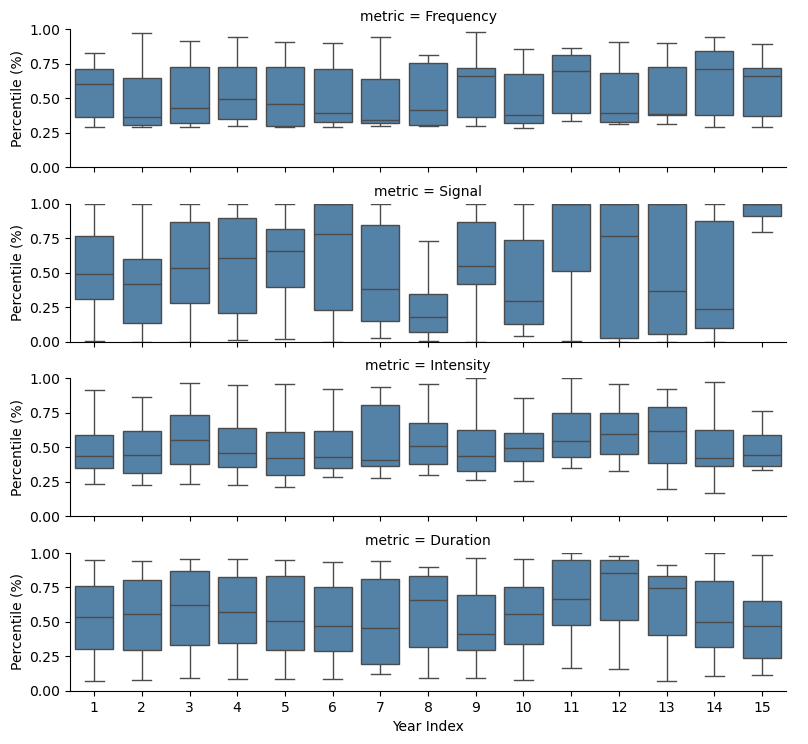

In [9]:
# ── keep only rows with valid data ──
plot_df = (
    percentiles
      .dropna(subset=["percentile", "time_index"])
      .copy()
)
plot_df["time_index"] = plot_df["time_index"].astype(int)

# ── Faceted boxplots: 1 row per metric ──
g = sns.catplot(
        data=plot_df,
        x="time_index",
        y="percentile",
        row="metric",            # 4 separate rows
        kind="box",
        height=2.0, aspect=4.0,  # tweak dimensions to taste
        sharex=True, sharey=True,
        showfliers=False,
        color="steelblue"
    )

# ---- axis labels & formatting ----
g.set_axis_labels("Year Index",
                  "Percentile (%)")
g.set(ylim=(0, 1))
g.fig.subplots_adjust(top=0.9)

plt.show()

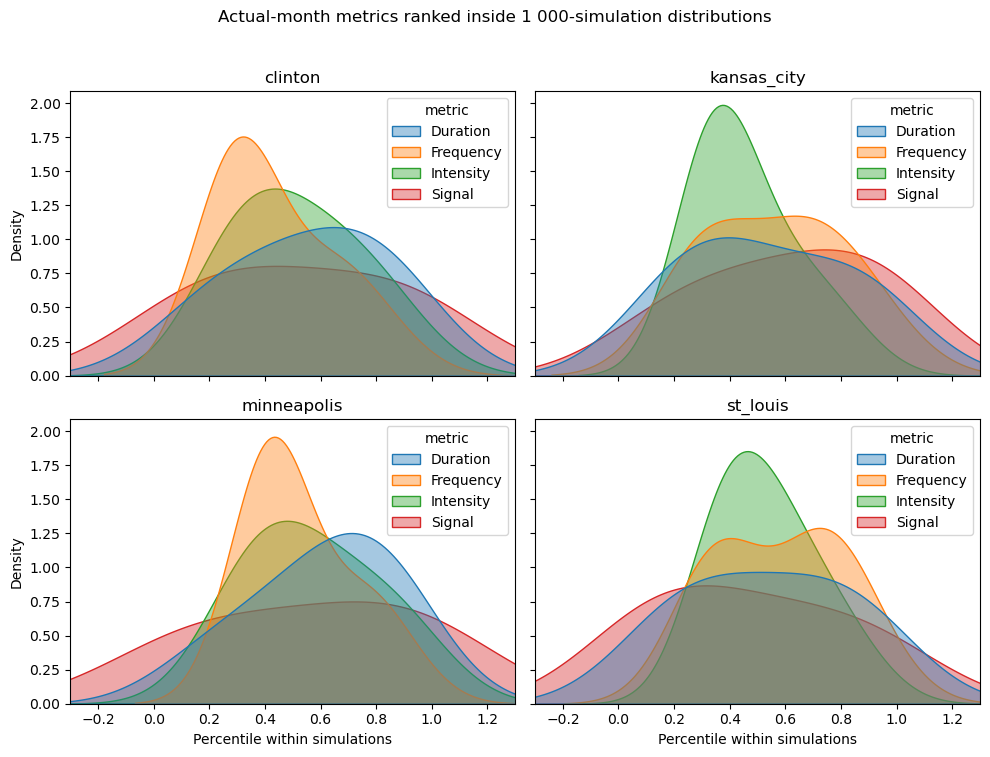

In [10]:
# ── 1. Prep ─────────────────────────────────────────────
# Ensure 'location' and 'metric' are categorical to preserve ordering
percentiles["location"] = percentiles["location"].astype("category")
percentiles["metric"]   = percentiles["metric"].astype("category")

locs   = percentiles["location"].cat.categories
n_locs = len(locs)

# ── 2. Create a 2×2 grid of axes ────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()                          # 1-D iterator is handy

# ── 3. Plot one KDE per axis ───────────────────────────
for ax, loc in zip(axes, locs):
    sns.kdeplot(
        data=percentiles.query("location == @loc"),
        x="percentile",
        hue="metric",
        common_norm=False,
        fill=True,
        alpha=0.4,
        linewidth=1,
        bw_adjust=2.5,
        ax=ax
    )
    ax.set_title(loc)
    ax.set_xlim(-0.3, 1.3)
    ax.set_xlabel("Percentile within simulations")
    ax.set_ylabel("Density")

fig.suptitle("Actual-month metrics ranked inside 1 000-simulation distributions", y=0.94)
fig.tight_layout(rect=[0, 0, 1, 0.92])         # leave room for legend/title
plt.show()

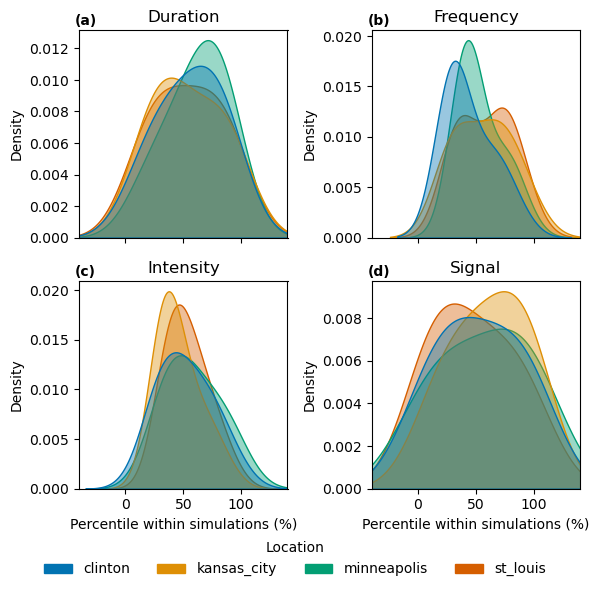

In [11]:
# ── 0. Prep categorical ordering ────────────────────────────
percentiles["metric"]   = percentiles["metric"].astype("category")
percentiles["location"] = percentiles["location"].astype("category")

metrics      = percentiles["metric"].cat.categories
locations    = percentiles["location"].cat.categories
palette      = sns.color_palette("colorblind", n_colors=len(locations))
color_lookup = dict(zip(locations, palette))

# ── 1. Figure & axes (NO shared y) ──────────────────────────
fig, axes = plt.subplots(
    2, 2, figsize=(6, 6),   # 6 in wide, 7.2 in tall keeps ≈1.2 aspect
    sharex=True, sharey=False
)
axes = axes.flatten()
panel_labels = ['a', 'b', 'c', 'd']           # for sub-labels

# ── 2. Plot per metric ──────────────────────────────────────
for ax, metric, label in zip(axes, metrics, panel_labels):
    df_sub = percentiles.query("metric == @metric").copy()
    df_sub["percentile_100"] = df_sub["percentile"] * 100  # 0–100 scale

    sns.kdeplot(
        data=df_sub,
        x="percentile_100",
        hue="location",
        hue_order=locations,
        palette=color_lookup,
        common_norm=False,
        fill=True,
        alpha=0.4,
        linewidth=1,
        bw_adjust=2.5,
        ax=ax,
        legend=False          # suppress per-axes legends entirely
    )

    # styling
    ax.set_title(metric)
    ax.set_xlim(-40, 140)      # a little padding
    ax.set_xlabel("Percentile within simulations (%)")
    ax.set_ylabel("Density")
    ax.text(-0.02, 1.08, f"({label})", transform=ax.transAxes,
            ha="left", va="top", fontsize="medium", fontweight="bold")

# ── 3. Custom legend underneath ─────────────────────────────
legend_handles = [
    mpatches.Patch(color=color_lookup[loc], label=loc) for loc in locations
]

fig.legend(
    handles=legend_handles,
    title="Location",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),    # just below the figure
    ncol=4,                         # 4 columns
    frameon=False
)

fig.tight_layout(rect=[0, 0.05, 1, 0.97])    # leave space for title & legend
if save:
    plt.savefig("Plots/Simulation_KDE.png", dpi=500)
plt.show()

In [12]:
kdf = df_sub

/tmp/ipykernel_2523/642598297.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.05, 1])   # room for the legend


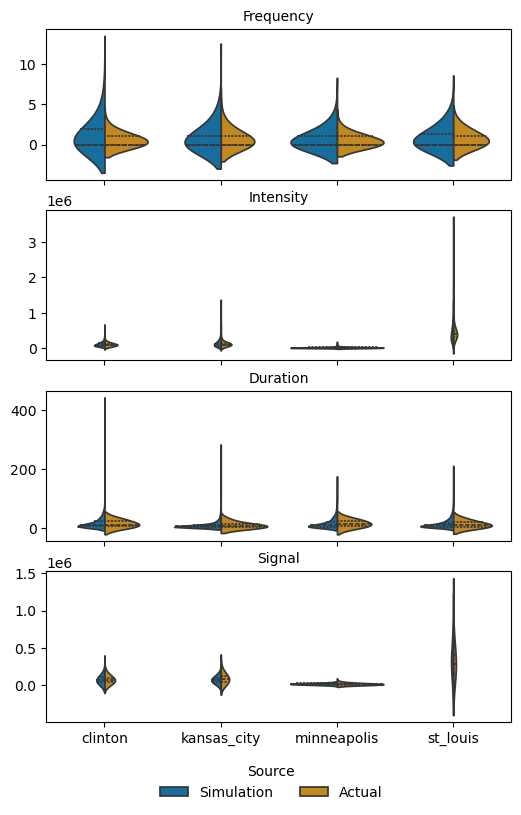

In [13]:
# ── 0.  Prepare data ─────────────────────────────────────────────
metrics      = ["frequency", "intensity", "duration", "signal"]
location_ord = sorted(long["location"].unique())           # keep a fixed order
source_ord   = ["Simulation", "Actual"]                    # ensure split order

# ── 1.  Set figure & axes (4 stacked rows) ──────────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(6, 9),          # narrow width, taller for four rows
    sharex=True, sharey=False
)

palette = {"Simulation": sns.color_palette("colorblind")[0],
           "Actual":      sns.color_palette("colorblind")[1]}

# ── 2.  Plot each metric ────────────────────────────────────────
for ax, metric in zip(axes, metrics):
    df_sub = long.query("metric == @metric")

    sns.violinplot(
        data=df_sub,
        x="location",
        y="value",
        hue="source",
        order=location_ord,
        hue_order=source_ord,
        split=True,              # <— split violins
        inner="quart",
        palette=palette,
        bw_adjust=4,
        ax=ax
    )

    # cosmetic tweaks
    ax.set_title(metric.capitalize(), loc="center", fontsize="medium")
    ax.set_xlabel("")           # remove individual x labels
    ax.set_ylabel("")           # optional, keeps panels compact
    ax.legend_.remove()         # remove per-panel legends

# ── 3.  Global legend & layout tweaks ───────────────────────────
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Source",
    loc="lower center", ncol=2, frameon=False,
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout(rect=[0, 0, 0.05, 1])   # room for the legend
plt.show()

In [14]:
# ------------------------------------------------------------------
# 3-A.  Mask metric-wise outliers   (const = no. σ above mean) ──────
# ------------------------------------------------------------------
const = 3          # e.g. keep everything within 3 σ of the mean

# df_sub is the long-format frame you built earlier
long = (
    long
    .groupby("metric", group_keys=False, observed=True)
    .apply(strip_upper_outliers, k=const)
)

#df_sub = long

/tmp/ipykernel_2523/3889792048.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(strip_upper_outliers, k=const)


/tmp/ipykernel_2523/642598297.py:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.05, 1])   # room for the legend


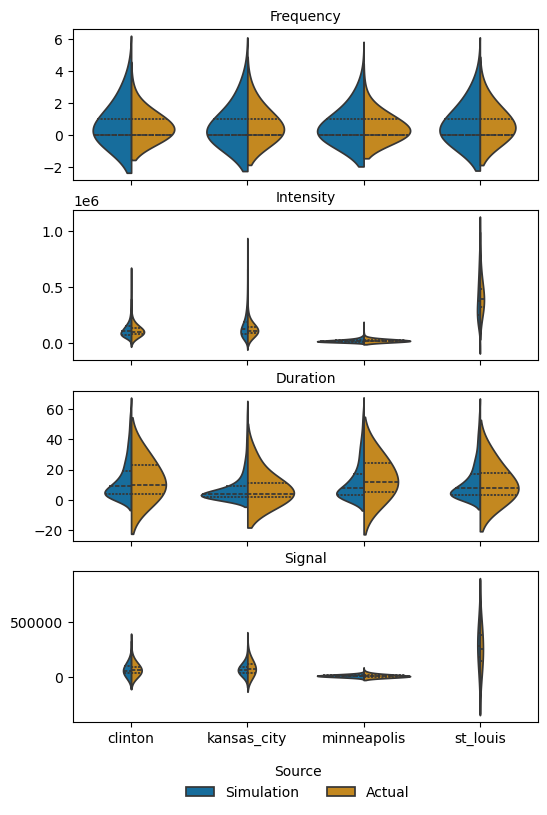

In [15]:
# ── 0.  Prepare data ─────────────────────────────────────────────
metrics      = ["frequency", "intensity", "duration", "signal"]
location_ord = sorted(long["location"].unique())           # keep a fixed order
source_ord   = ["Simulation", "Actual"]                    # ensure split order

# ── 1.  Set figure & axes (4 stacked rows) ──────────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(6, 9),          # narrow width, taller for four rows
    sharex=True, sharey=False
)

palette = {"Simulation": sns.color_palette("colorblind")[0],
           "Actual":      sns.color_palette("colorblind")[1]}

# ── 2.  Plot each metric ────────────────────────────────────────
for ax, metric in zip(axes, metrics):
    df_sub = long.query("metric == @metric")

    sns.violinplot(
        data=df_sub,
        x="location",
        y="value",
        hue="source",
        order=location_ord,
        hue_order=source_ord,
        split=True,              # <— split violins
        inner="quart",
        palette=palette,
        bw_adjust=4,
        ax=ax
    )

    # cosmetic tweaks
    ax.set_title(metric.capitalize(), loc="center", fontsize="medium")
    ax.set_xlabel("")           # remove individual x labels
    ax.set_ylabel("")           # optional, keeps panels compact
    ax.legend_.remove()         # remove per-panel legends

# ── 3.  Global legend & layout tweaks ───────────────────────────
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Source",
    loc="lower center", ncol=2, frameon=False,
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout(rect=[0, 0, 0.05, 1])   # room for the legend
plt.show()

/tmp/ipykernel_2523/330926281.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_2523/330926281.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_2523/330926281.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_2523/330926281.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


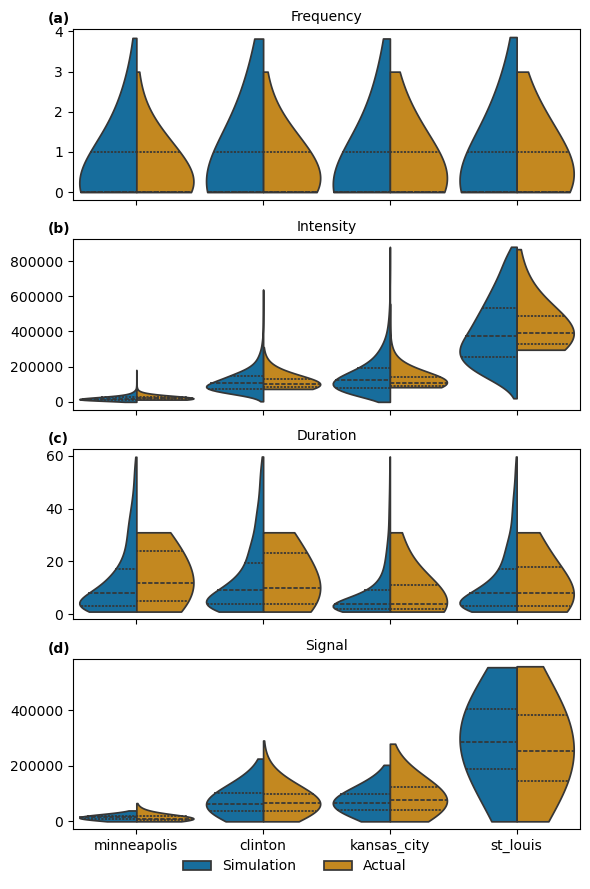

In [16]:
# ── 0.  Prepare data ─────────────────────────────────────────────
metrics = ["frequency", "intensity", "duration", "signal"]

# Force the location column to follow the required order
location_ord = ["minneapolis", "clinton", "kansas_city", "st_louis"]
long["location"] = pd.Categorical(long["location"], categories=location_ord, ordered=True)

source_ord = ["Simulation", "Actual"]
palette    = {"Simulation": sns.color_palette("colorblind")[0],
              "Actual":      sns.color_palette("colorblind")[1]}
panel_labels = ['a', 'b', 'c', 'd']

# ── 1.  Figure & axes ────────────────────────────────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=1,
    figsize=(6, 9),
    sharex=True, sharey=False
)

# ── 2.  Plot each metric ────────────────────────────────────────
for ax, metric, label in zip(axes, metrics, panel_labels):
    df_sub = long.query("metric == @metric")

    sns.violinplot(
        data=df_sub,
        x="location",
        y="value",
        hue="source",
        order=location_ord,      # enforce x-axis order
        hue_order=source_ord,
        split=True,
        inner="quart",
        palette=palette,
        bw_adjust=4,
        scale='width',
        width=0.9,
        cut=0, #2 if prettier, but tails inaccurate
        ax=ax
    )

    # cosmetics
    ax.set_title(metric.capitalize(), loc="center", fontsize="medium")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(-0.05, 1.1, f"({label})", transform=ax.transAxes,
            ha="left", va="top", fontsize="medium", fontweight="bold")
    ax.legend_.remove()

# ── 3.  Global legend & layout ──────────────────────────────────
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="lower center", ncol=2, frameon=False,
    bbox_to_anchor=(0.5, 0.01)
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
if save:
    plt.savefig("Plots/Violins.png", dpi=500)
plt.show()

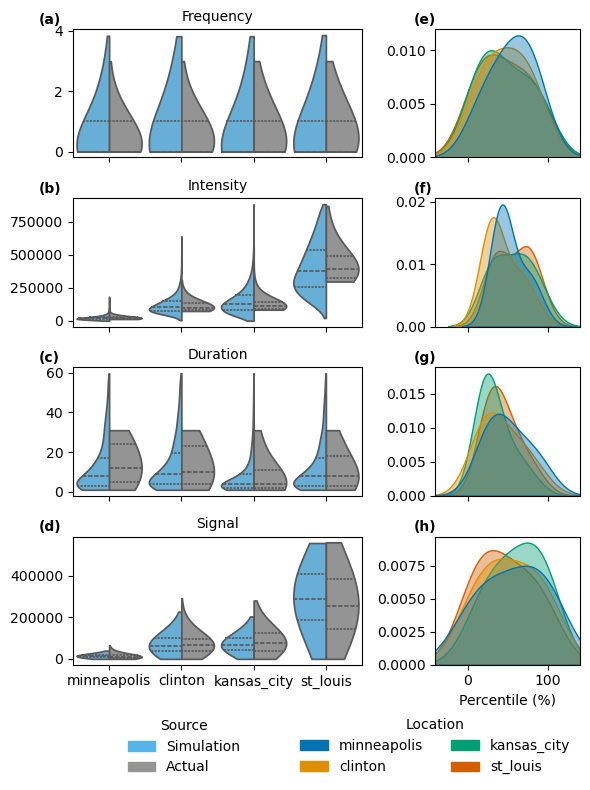

In [17]:
# ── 0.  House-keeping & palettes ────────────────────────────
metrics       = ["frequency", "intensity", "duration", "signal"]
location_ord  = ["minneapolis", "clinton", "kansas_city", "st_louis"]
source_ord    = ["Simulation", "Actual"]

palette_src   = {"Simulation": sns.color_palette("colorblind")[9],
                 "Actual":      sns.color_palette("colorblind")[7]}
palette_loc   = sns.color_palette("colorblind", n_colors=len(location_ord))
loc_lookup    = dict(zip(location_ord, palette_loc))
panel_labels  = ['a', 'b', 'c', 'd']

# Ensure categorical ordering everywhere
long["location"]      = pd.Categorical(long["location"],
                                       categories=location_ord, ordered=True)
percentiles["location"] = pd.Categorical(percentiles["location"],
                                         categories=location_ord, ordered=True)
percentiles["metric"]   = pd.Categorical(percentiles["metric"],
                                         categories=metrics,      ordered=True)

# ── 1.  Figure with 4 rows × 2 cols (3:1 width) ────────────────
fig, axes = plt.subplots(
    nrows=4, ncols=2,
    figsize=(6, 8),                    # same overall width
    sharex='col', sharey=False,
    gridspec_kw={"width_ratios": [2, 1]}  # ⟵  left:right = 2:1
)

# Left col = violins ─────────────────────────────────────────
for row_idx, metric in enumerate(metrics):
    ax = axes[row_idx, 0]
    dfv = long.query("metric == @metric")
    
    sns.violinplot(
        data=dfv,
        x="location", y="value",
        hue="source",
        order=location_ord,
        hue_order=source_ord,
        split=True, inner="quart",
        palette=palette_src,
        bw_adjust=4, density_norm='width', legend=False, width=0.9, cut=0,
        ax=ax
    )
    
    ax.set_title(metric.capitalize(), loc="center", fontsize="medium")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(-0.12, 1.13, f"({panel_labels[row_idx]})",
            transform=ax.transAxes,
            ha="left", va="top", fontsize="medium", fontweight="bold")

# ------------------------------------------------------------------
# 2. Percentiles of ACTUAL within SIM distributions (time-specific)
# ------------------------------------------------------------------
records = []

for loc in actual_df["location"].unique():
    a_loc = actual_df[actual_df["location"] == loc]
    s_loc = sim_monthly[sim_monthly["location"] == loc]

    for _, row in a_loc.iterrows():
        time_idx = row["time_index"]
        month = row["month"]

        s_t = s_loc[s_loc["time_index"] == time_idx]  # simulations at same time step

        for m in metrics:
            sims = np.sort(s_t[m].values)  # ECDF for this timestep
            actual_val = row[m]
            r = np.searchsorted(sims, actual_val, side="right")
            pct = r / sims.size if sims.size > 0 else np.nan

            records.append({
                "location": loc,
                "metric": m.capitalize(),
                "month": month,
                "time_index": time_idx,
                "percentile": pct
            })

percentiles = pd.DataFrame(records)

# ── 0. Prep categorical ordering ────────────────────────────
percentiles["metric"]   = percentiles["metric"].astype("category")
percentiles["location"] = percentiles["location"].astype("category")

metrics      = percentiles["metric"].cat.categories
locations    = percentiles["location"].cat.categories

panel_labels  = ['e', 'f', 'g', 'h']

# Right col = KDEs ───────────────────────────────────────────
for row_idx, metric in enumerate(metrics):
    ax = axes[row_idx, 1]
    dfk = percentiles.query("metric == @metric").copy()
    dfk["percentile_100"] = dfk["percentile"] * 100
    
    sns.kdeplot(
        data=dfk,
        x="percentile_100",
        hue="location",
        hue_order=location_ord,
        palette=loc_lookup,
        common_norm=False,
        fill=True, alpha=0.4, linewidth=1, bw_adjust=2.5,
        ax=ax, legend=False
    )
    
    ax.set_title("")  # left panel already has the metric title
    ax.set_xlabel("Percentile (%)")
    ax.set_ylabel("")
    ax.set_xlim(-40, 140)

    ax.text(-0.15, 1.13, f"({panel_labels[row_idx]})",
        transform=ax.transAxes,
        ha="left", va="top", fontsize="medium", fontweight="bold")

# ── 2.  Combined legends ───────────────────────────────────
# Source legend (violins)
handles_src = [mpatches.Patch(color=palette_src[s], label=s) for s in source_ord]
fig.legend(handles_src, source_ord, title="Source",
           loc="lower left", bbox_to_anchor=(0.2, 0.01),
           frameon=False, ncol=1)

# Location legend (KDEs)
handles_loc = [mpatches.Patch(color=loc_lookup[loc], label=loc) for loc in location_ord]
fig.legend(handles_loc, location_ord, title="Location",
           loc="lower right", bbox_to_anchor=(0.98, 0.01),
           frameon=False, ncol=2)

# ── 3.  Layout tweaks ──────────────────────────────────────
plt.tight_layout(rect=[0, 0.09, 1, 1])  # leave space for legends
if save:
    plt.savefig("Plots/Combined_Validation.png", dpi=500)
plt.show()